## Car Segmentation using UNet Architecture and Pytorch

This is a sample semantic image segmentation task on a [car-segmentation](https://www.kaggle.com/datasets/intelecai/car-segmentation) dataset. This dataset contains images of cars and their segmentation masks. Most of the images were taken from side of the car. Image and its corresponding mask have the same name. For example, 003.png in the "masks" folder corresponds to the 003.png file in the "images" folder. Each pixel in a mask shows the class of the corresponding pixel in the corresponding image. For example, if value of pixel (3, 7) is 1, it means pixel (3,7) in the corresponding image belongs to class 1. We have following 5 classes in this dataset:

- 0 = background
- 1 = car
- 2 = wheel
- 3 = lights
- 4 = window

In [1]:
import cv2
import copy
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from torch.utils.data import Subset, Dataset, DataLoader
import torch
import torch.nn.functional as F 
from torchmetrics.classification import Dice
from torchvision.transforms import transforms
from tqdm.notebook import tqdm

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'using {device}')

using cuda


In [3]:
ROOT_DIR =  './car-segmentation'

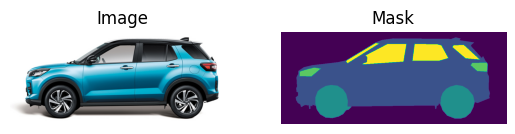

In [4]:
# img = cv2.imread(f"{ROOT_DIR}/images/003.png")
# mask = cv2.imread(f"{ROOT_DIR}//masks/003.png")
img = plt.imread(f"{ROOT_DIR}/images/003.png")
mask = plt.imread(f"{ROOT_DIR}//masks/003.png")
plt.subplot(1,2,1)
plt.imshow(img)
plt.title('Image')
plt.axis(False)
plt.subplot(1,2,2)
# plt.imshow(mask[:,:,0]) # If cv2 is used to read image
plt.imshow(mask)
plt.title('Mask')
plt.axis(False)
plt.show()

In [5]:
len(os.listdir(f"{ROOT_DIR}/images/")), len(os.listdir(f"{ROOT_DIR}/masks/"))

(211, 211)

In [6]:
with open(f"{ROOT_DIR}/classes.txt", 'r') as f:
    classes_file = f.read()

In [7]:
classes = classes_file[0:-1]
print(classes)
classes_list = classes.split(',')

background,car,wheel,lights,window


In [8]:
l = len(classes_list)
classes_list, len(classes_list)

(['background', 'car', 'wheel', 'lights', 'window'], 5)

In [9]:
with open(f"{ROOT_DIR}/masks.json", 'r') as f:
    json_file = json.load(f)

In [10]:
IMG_HEIGHT = 256 # 256  # 512, 256
IMG_WIDTH = 512 # 512  # 1024, 256
SIZE = (IMG_HEIGHT, IMG_WIDTH)

BATCH_SIZE = 22
LR = 1e-3
num_epochs = 10

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

In [11]:
class CarDataset(Dataset):
    def __init__(self,image_dir , mask_dir, size=SIZE):
      super().__init__()
      self.image_dir = image_dir
      self.mask_dir = mask_dir
      self.image_list = os.listdir(self.image_dir)
      self.mask_list = os.listdir(self.mask_dir)
      self.transform_img = transforms.Compose([
          transforms.ToTensor(),
          transforms.Resize(size, antialias=True), # default is bilinear
          # transforms.Resize(size, transforms.InterpolationMode.BICUBIC, antialias=True),
          # transforms.RandomHorizontalFlip(p=0.5),
          # transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0),
          # transforms.Normalize(mean, std)    
      ])
      self.size = size
    def __getitem__(self,index):
      img = cv2.imread(self.image_dir+self.image_list[index])
      mask = cv2.imread(self.mask_dir+self.mask_list[index])[:,:,0]
      img = self.transform_img(img)
      mask = torch.from_numpy(cv2.resize(mask, (self.size[1], self.size[0]))).squeeze().to(torch.long)
      return img , mask
    def __len__(self):
      return len(self.image_list)

car_data = CarDataset(f"{ROOT_DIR}/images/",f"{ROOT_DIR}/masks/")
car_dataloader = DataLoader(car_data, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


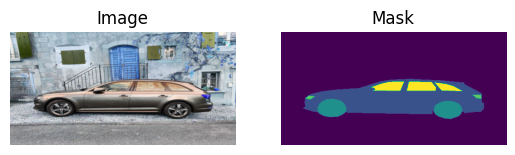

In [12]:
for i in car_dataloader:
    img , mask = i
    plt.subplot(1,2,1)
    plt.imshow(img[0].permute(1,2,0))
    plt.title('Image')
    plt.axis(False)
    plt.subplot(1,2,2)
    plt.imshow(mask[0])
    plt.title('Mask')
    plt.axis(False)
    plt.show()
    break

In [13]:
def plot_example(image, mask, mask_tags=None):
    plt.figure(figsize=(20, 10))
    ncols = num_classes
    nrows = 2 if mask_tags is None else 3
    
    # Plot image
    plt.subplot(nrows, ncols, 1)
    plt.imshow(image)
    plt.title("Image")
    plt.axis("off")

    # Plot mask
    plt.subplot(nrows, ncols, 2)
    plt.imshow(mask)
    plt.title("Mask")
    plt.axis("off")
        
    # plot each channel in prediction
    if mask_tags is not None:
        for i in range(num_classes):
            mask_channel = mask_tags[:, :, i] 
            plt.subplot(nrows, ncols, i+num_classes*2+1)
            plt.imshow(mask_channel)
            plt.title(f"Tag: {classes_list[i]}")
            plt.axis("off")

    plt.tight_layout()
    plt.show()

In [14]:
image, mask = next(iter(car_dataloader))
print('image: ', image.shape)
print('mask: ', mask.shape)

image:  torch.Size([22, 3, 256, 512])
mask:  torch.Size([22, 256, 512])


In [15]:
image_0 = image[0,:,:,:].permute(1,2,0)
print(image_0.shape)
mask_0 = mask[0,:,:]
num_classes = len(classes_list)
mask_0_tags = F.one_hot(mask_0, num_classes)

torch.Size([256, 512, 3])


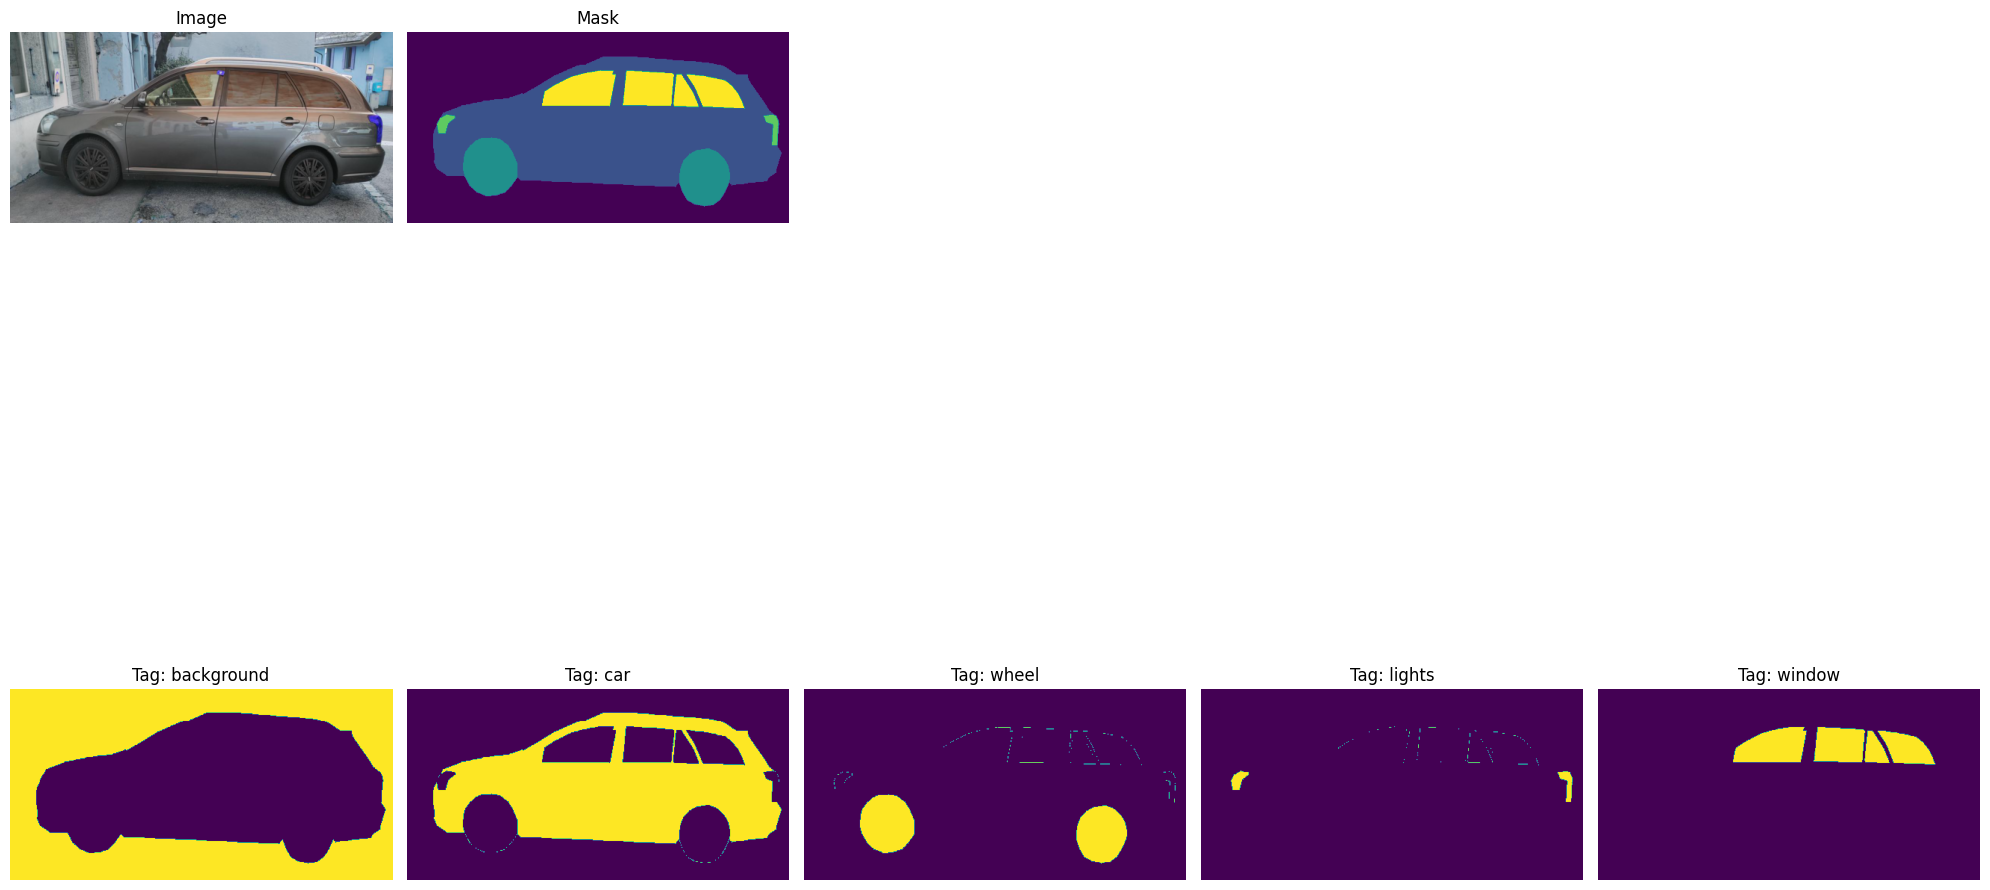

In [16]:
plot_example(image_0, mask_0, mask_0_tags)

In [17]:
train_val_split_ratio = 0.2
train_inds = range(int(len(car_data)*(1-train_val_split_ratio)))
val_inds = range(int(len(car_data)*(1-train_val_split_ratio)), len(car_data))
print(f"Training N: {len(train_inds)}")
print(f"Validation N: {len(val_inds)}")

train_dataset = Subset(car_data, train_inds)
val_dataset = Subset(car_data, val_inds)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, pin_memory=True)

dataloaders = dict()
dataloaders['train'] = train_loader
dataloaders['val'] = val_loader

Training N: 168
Validation N: 43


In [19]:
import torch.nn as nn
class conv_block(nn.Module):
    def __init__(self, inc, ouc):
        super().__init__()
        self.cb = nn.Sequential(
            nn.Conv2d(inc, ouc, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(ouc),
            nn.ReLU(inplace=True)
        )
    def forward(self,input_tensor):
        output_tensor = self.cb(input_tensor)
        return output_tensor
class up_block(nn.Module):
    def __init__(self,inc,ouc) -> None:
        super().__init__()
        self.up = nn.ConvTranspose2d(inc,ouc,kernel_size=4,padding=1,stride=2)
    def forward(self,input_tensor):
        output_tensor = self.up(input_tensor)
        return output_tensor
class UNet(nn.Module):
    """
    UNet-like implementation. More details about UNet is available on 'U-Net: Convolutional Networks 
    for Biomedical Image Segmentation' paper. 
    """
    def __init__(self, input_channels, num_class):
        super().__init__()
        self.pool_layer = nn.MaxPool2d(kernel_size=2,stride=2)
        self.enc1 = conv_block(input_channels,16)
        self.enc2 = conv_block(16,32)
        self.enc3 = conv_block(32,64)
        self.enc4 = conv_block(64,128)
        self.enc5 = conv_block(128,256)
        self.enc6 = conv_block(256, 512)

        self.bridge = conv_block(512,1024)

        self.up6 = up_block(1024,512)
        self.dec6 = conv_block(512*2,256)
        self.up5 = up_block(256,256)
        self.dec5 = conv_block(256*2,128)
        self.up4 = up_block(128,128)
        self.dec4 = conv_block(128*2,64)
        self.up3 = up_block(64,64)
        self.dec3 = conv_block(64*2,32)
        self.up2 = up_block(32,32)
        self.dec2 = conv_block(32*2,16)
        self.up1 = up_block(16,16)
        self.dec1 = conv_block(16*2,16)

        self.out = nn.Conv2d(16, num_class, kernel_size=3, padding=1)

    def forward(self, input_tensor):
        x = input_tensor
        
        # Contraction path, Encoder
        e1 = self.enc1(input_tensor)
        x = self.pool_layer(e1)
        e2 = self.enc2(x)
        x = self.pool_layer(e2)
        e3 = self.enc3(x)
        x = self.pool_layer(e3)
        e4 = self.enc4(x)
        x = self.pool_layer(e4)
        e5 = self.enc5(x)
        x = self.pool_layer(e5)
        e6 = self.enc6(x)
        x = self.pool_layer(e6)
        
        # Bottleneck
        x = self.bridge(x)  
        
        # Expansive path, Decoder
        x = self.up6(x)
        x = torch.cat((e6, x),dim=1)
        x = self.dec6(x)
        x = self.up5(x)
        x = torch.cat((e5, x),dim=1)
        x = self.dec5(x)
        x = self.up4(x)
        x = torch.cat((e4, x),dim=1)
        x = self.dec4(x)
        x = self.up3(x)
        x = torch.cat((e3,x),dim=1)
        x = self.dec3(x)
        x = self.up2(x)
        x = torch.cat((e2,x),dim=1)
        x = self.dec2(x)
        x = self.up1(x)
        x = torch.cat((e1,x),dim=1)
        x = self.dec1(x)
        
        output = self.out(x)
        
        return output

In [20]:
model = UNet(3, 5).to(device)
print(model)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR, amsgrad=True)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=1)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
# scheduler = torch.optim.MultiStepLR(optimizer, milestones=[20,40], gamma=0.1)

UNet(
  (pool_layer): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc1): conv_block(
    (cb): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
  )
  (enc2): conv_block(
    (cb): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
  )
  (enc3): conv_block(
    (cb): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
  )
  (enc4): conv_block(
    (cb): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), paddin

In [21]:
import sys
dice_metric = Dice(num_classes=5, threshold=0.7).to(device)

train_epoch_loss, val_epoch_loss = [], []
train_epoch_metric, val_epoch_metric = [], []

def train(model, optim, criterion, dataloader, epochs):
    for epoch in range(1,epochs+1):
        losses = []
        metrics = []
        for idx, (img, mask) in enumerate(dataloader):
            img = img.to(device)
            mask = mask.to(device)
            optim.zero_grad()
            out = model(img)
            metric = dice_metric(out.argmax(axis=1), mask)
            loss = criterion(out,mask)
            loss.backward()
            optim.step()
            losses.append(loss.item())
            metrics.append(metric.item())
            sys.stdout.write(f"\r EPOCH [{epoch}/{epochs}] IDX [{idx+1}/{len(dataloader)}] batch_loss={loss.item():.5f}, running_loss={(sum(losses)/len(losses)):.5f}, dice_metric={(sum(metrics)/len(metrics)):.5f}")
        
        mean_loss = sum(losses)/len(losses)
        scheduler.step(mean_loss)

        mean_metric = sum(metrics)/len(metrics)
        train_epoch_loss.append(mean_loss)
        train_epoch_metric.append(mean_metric)
        
        print()

    # Save the trained model
    print('Saving Model.......')
    if not os.path.exists('saved_model'):
        os.mkdir('saved_model')
    torch.save(model.state_dict(), './saved_model/UNet_model_100epochs_256x512input.pth')

In [22]:
import sys
dice_metric = Dice(num_classes=5, threshold=0.7).to(device)

train_epoch_loss, val_epoch_loss = [], []
train_epoch_metric, val_epoch_metric = [], []

def train_val(model, optimizer, criterion, dataloaders, epochs):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_metric = 0.0
    for epoch in range(1,epochs+1):
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluate mode
            train_losses, val_losses = [], []
            train_metrics, val_metrics = [], []
            for idx, (img, mask) in enumerate(dataloaders[phase]):
                img = img.to(device)
                mask = mask.to(device)
                # Forward pass - track history if only in train
                with torch.set_grad_enabled(phase == 'train'):                
                    out = model(img)
                    metric = dice_metric(out.argmax(axis=1), mask)
                    loss = criterion(out,mask)
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()
                        train_losses.append(loss.item())
                        train_metrics.append(metric.item())
                        sys.stdout.write(f"\r EPOCH [{epoch}/{epochs}] IDX [{idx+1}/{len(dataloaders[phase])}] {phase}, batch_loss={loss.item():.5f}, running_loss={(sum(train_losses)/len(train_losses)):.5f}, dice_metric={(sum(train_metrics)/len(train_metrics)):.5f}")
                    else:
                        val_losses.append(loss.item())
                        val_metrics.append(metric.item())
                        sys.stdout.write(f"\r EPOCH [{epoch}/{epochs}] IDX [{idx+1}/{len(dataloaders[phase])}] {phase}, batch_loss={loss.item():.5f}, running_loss={(sum(val_losses)/len(val_losses)):.5f}, dice_metric={(sum(val_metrics)/len(val_metrics)):.5f}")
            
            if phase == 'train':
                mean_train_loss = sum(train_losses)/len(train_losses)
                scheduler.step(mean_train_loss) # Todo: mean_train_loss or mean_val_metric? 
                mean_train_metric = sum(train_metrics)/len(train_metrics)
                train_epoch_loss.append(mean_train_loss)
                train_epoch_metric.append(mean_train_metric)
            else:
                mean_val_loss = sum(val_losses)/len(val_losses)
                mean_val_metric = sum(val_metrics)/len(val_metrics)
                val_epoch_loss.append(mean_val_loss)
                val_epoch_metric.append(mean_val_metric)
                epoch_val_metric = mean_val_metric

            # Deep copy the model
            if phase == 'val' and epoch_val_metric > best_metric:
                best_metric = epoch_val_metric
                best_model_wts = copy.deepcopy(model.state_dict())
            
            print()

    # Load best model weights
    model.load_state_dict(best_model_wts)
    
    # Save the trained model
    print('Saving Model.......')
    if not os.path.exists('saved_model'):
        os.mkdir('saved_model')
    torch.save(model.state_dict(), './saved_model/UNet_model_100epochs_256x512input.pth')

In [23]:
# train(model, optimizer, criterion, train_loader, epochs=10)  # Train on all unsplitted dataset
train_val(model, optimizer, criterion, dataloaders, epochs=10)  # Train and val on splitted dataset

 EPOCH [1/100] IDX [8/8] train, batch_loss=1.31668, running_loss=1.62565, dice_metric=0.31133
 EPOCH [1/100] IDX [2/2] val, batch_loss=1.49156, running_loss=1.48329, dice_metric=0.56765
 EPOCH [2/100] IDX [8/8] train, batch_loss=0.82212, running_loss=1.00725, dice_metric=0.75212
 EPOCH [2/100] IDX [2/2] val, batch_loss=1.81423, running_loss=1.67471, dice_metric=0.70352
 EPOCH [3/100] IDX [8/8] train, batch_loss=0.69084, running_loss=0.68490, dice_metric=0.82946
 EPOCH [3/100] IDX [2/2] val, batch_loss=0.68297, running_loss=0.64125, dice_metric=0.81981
 EPOCH [4/100] IDX [8/8] train, batch_loss=0.65271, running_loss=0.55980, dice_metric=0.83611
 EPOCH [4/100] IDX [2/2] val, batch_loss=0.63232, running_loss=0.57126, dice_metric=0.84006
 EPOCH [5/100] IDX [8/8] train, batch_loss=0.53742, running_loss=0.48623, dice_metric=0.84465
 EPOCH [5/100] IDX [2/2] val, batch_loss=0.87443, running_loss=0.74252, dice_metric=0.82822
 EPOCH [6/100] IDX [8/8] train, batch_loss=0.47107, running_loss=0.447

In [47]:
import sys
dice_metric = Dice(num_classes=5, threshold=0.7).to(device)

def evaluate(model, dataloader):
        metrics = []
        print('Evaluating ...')
        for idx, (img, mask) in enumerate(dataloader):
            img = img.to(device)
            mask = mask.to(device)
            out = model(img)
            metric = dice_metric(out.argmax(axis=1), mask)
            metrics.append(metric.item())
            sys.stdout.write(f"\r IDX [{idx+1}/{len(dataloader)}] dice_metric={(sum(metrics)/len(metrics)):.5f}")

        mean_metric = sum(metrics)/len(metrics)
                
        print()

        print(f"\r The dice metric on the test set is {mean_metric:.5f}")

In [48]:
# Load trained model for inference
model_weights = './saved_model/UNet_model_100epochs_256x512input.pth'
model.load_state_dict(torch.load(model_weights))
model.eval()
evaluate(model, val_loader)

Evaluating ...
 IDX [2/2] dice_metric=0.98104
 The dice metric on the test set is 0.98104


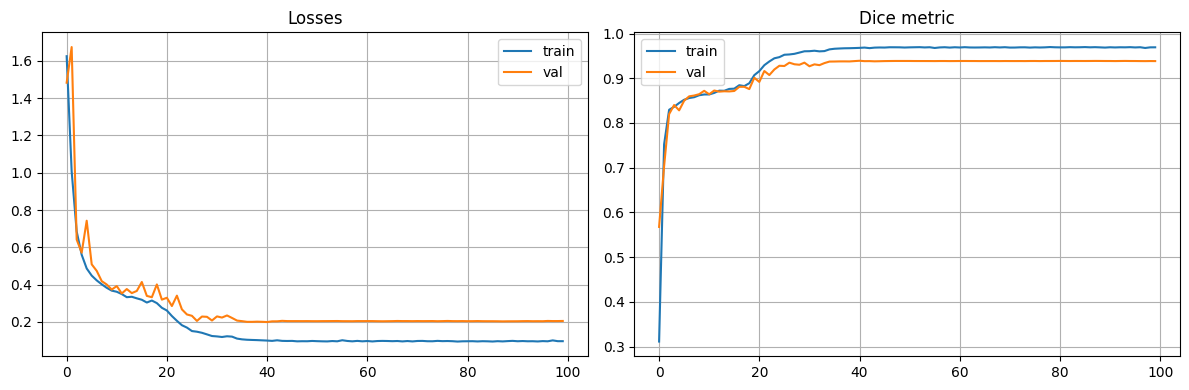

In [25]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize = (12, 4))
ax[0].plot(np.array(train_epoch_loss), label="train")
ax[0].plot(np.array(val_epoch_loss), label="val")
ax[0].set_title('Losses')
ax[0].grid(True)
ax[0].legend()

ax[1].plot(np.array(train_epoch_metric), label="train")
ax[1].plot(np.array(val_epoch_metric), label="val")
ax[1].set_title('Dice metric')
ax[1].grid(True)

ax[1].legend()

plt.tight_layout()
plt.show()

image size:  torch.Size([3, 256, 512])
mask size:  torch.Size([256, 512])
predicted mask size:  torch.Size([256, 512])


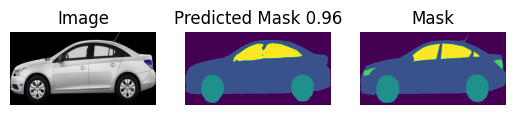

In [26]:
import torch.nn.functional as F
def dice_coefficient(img, img2):
    """
    Dice coefficient is a similarity metric commonly used in image segmentation, natural language 
    processing, and other fields where there is a need to measure the similarity between two sets.
    """
    if img.shape != img2.shape:
        raise ValueError("Shape mismatch: img and img2 must have to be of the same shape.")
    else:
        
        lenIntersection=0
        
        for i in range(img.shape[0]):
            for j in range(img.shape[1]):
                if ( np.array_equal(img[i][j],img2[i][j]) ):
                    lenIntersection+=1
         
        lenimg=img.shape[0]*img.shape[1]
        lenimg2=img2.shape[0]*img2.shape[1]  
        value = (2. * lenIntersection  / (lenimg + lenimg2))
    return value
    
for i in car_dataloader:
    img , mask = i
    plt.subplot(1,3,1)
    plt.imshow(img[0].permute(1,2,0))
    plt.title('Image')
    plt.axis(False)
    plt.subplot(1,3,2)
    img = img.to(device)
    with torch.no_grad():
        out = model(img)

    probs = F.softmax(out,dim=1)
    out = torch.argmax(probs, dim=1,keepdim=True)
    predicted_mask = out.detach().cpu().squeeze()
    dc = dice_coefficient(mask[0], predicted_mask[0])
    
    print('image size: ', img[0].shape)
    print('mask size: ', mask[0].shape)
    print('predicted mask size: ', predicted_mask[0].shape)
    
    plt.imshow(predicted_mask[0])
    plt.title(f'Predicted Mask {dc:.2f}')
    plt.axis(False)
    plt.subplot(1,3,3)
    plt.imshow(mask[0])
    plt.title('Mask')
    plt.axis(False)
    plt.show()
    break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


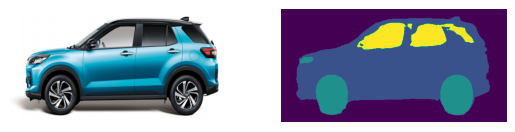

In [27]:
import requests
from PIL import Image
import numpy as np
from io import BytesIO

img = plt.imread('./car-segmentation/images/003.png')

img_array = np.array(img)
transform_img = transforms.Compose([
          transforms.ToTensor(),
          transforms.Resize(SIZE, antialias=True), # default is bilinear
          # transforms.Resize(size, transforms.InterpolationMode.BICUBIC, antialias=True),
          # transforms.Normalize(mean, std)  
      ])
tensor = transform_img(img_array)
with torch.no_grad():
        out = model(tensor.unsqueeze(dim=0).to(device))
probs = F.softmax(out,dim=1)
out = torch.argmax(probs, dim=1,keepdim=True)
mask = out.detach().cpu().squeeze()

plt.subplot(1,2,1)
plt.imshow(tensor.permute(1,2,0).detach().cpu().numpy())
plt.axis(False)


plt.subplot(1,2,2)
plt.imshow(mask)
plt.axis(False)

plt.show()
